In [1]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt

Q2:

In [3]:
stimulus = genfromtxt('stimSig.csv', delimiter=',')
spike_train = genfromtxt('spikeTrain.csv', delimiter=',')
fs = 2000 # samples/sec - sampling rate

In [20]:
spike_train = spike_train[1,:].astype(int)
stimulus = stimulus[1,:]


In [27]:
def calculate_STA(spike_train, stimulus, window):
    spike_indices = np.nonzero(spike_train==1)[0] # find all spike indices 
    STA_r = np.zeros((2*window,)) # initialize STA vector
    for idx in spike_indices:
        # if the the spike idx-window is smaller than 0, start at 0 (append zeros later at the begining for averaging purposes)
        start = max(0,int(idx-window)) 
        # If the the spike idx+window is larger than the length of the stimulus, end the slice at the lenth of the stimulus 
        # (append zeros later at the end for averaging purposes).
        end = min(len(stimulus), int(idx+window))
        slice = stimulus[start:end]
        if start == 0:
            slice = np.hstack((np.zeros((2*window-len(slice),)), slice))
        elif end == len(spike_train):
            slice = np.hstack((slice, np.zeros((2*window-len(slice),))))
        # add all stimulus slices around spikes and then average them
        STA_r+=slice 
    STA_average= STA_r/(len(spike_indices))
    return STA_average

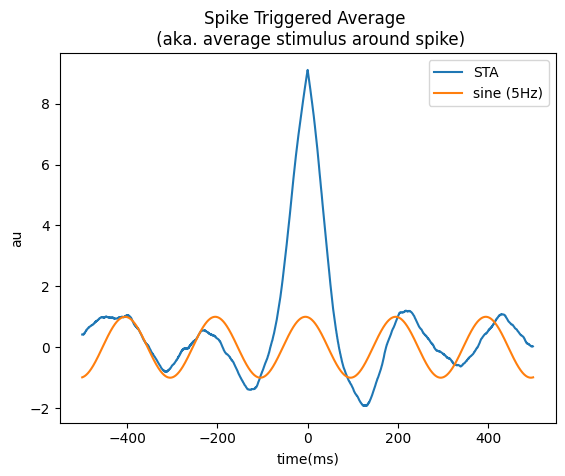

In [ ]:
x = np.arange(-500, 500, 0.5) # time relative to spike
f = 10 
T = 1 # sec
time = np.linspace(-500,500,T*fs) 
sine = np.sin(2*np.pi*f*time+30) # 5Hz sine with 30 degrees shift
# window is +-1000 samples because 2000 Hz sampling rate = 2000 samples/sec = 1000 samples/500 ms
STA = calculate_STA(spike_train, stimulus, 1000)
plt.plot(x,STA, label="STA")
plt.plot(time,sine, label = "sine (5Hz)")
plt.title('Spike Triggered Average \n (aka. average stimulus around spike)')
plt.xlabel('time(ms)')
plt.ylabel('au')
plt.legend()

From what is evident there are approximately 5 cycles of the signal in 1 sec, so the optimal sine to activate the neuron would be a 5Hz sine with a 30 degrees phase shift.

Q4:

In [2]:
resp_white = genfromtxt('resp.csv', delimiter=',')[1:,:].astype(int)
white_stim = genfromtxt('stim_kernel.csv', delimiter=',')[1,:]

In [5]:
recording_length = 60000
fs = 1000

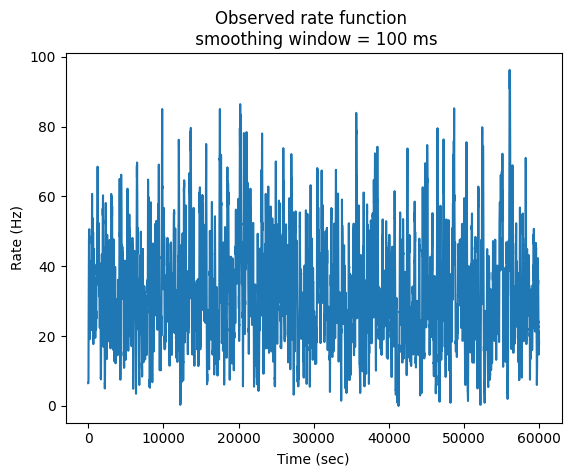

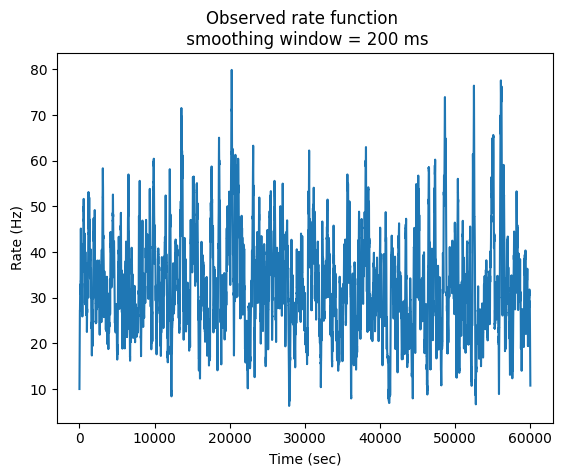

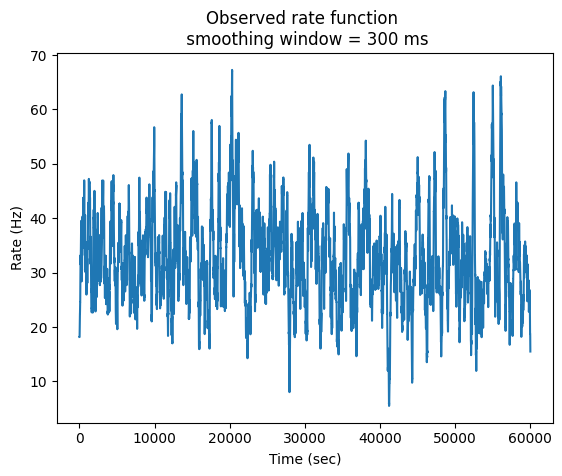

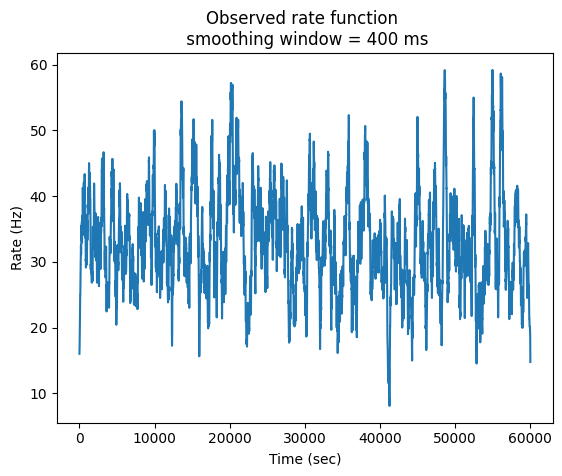

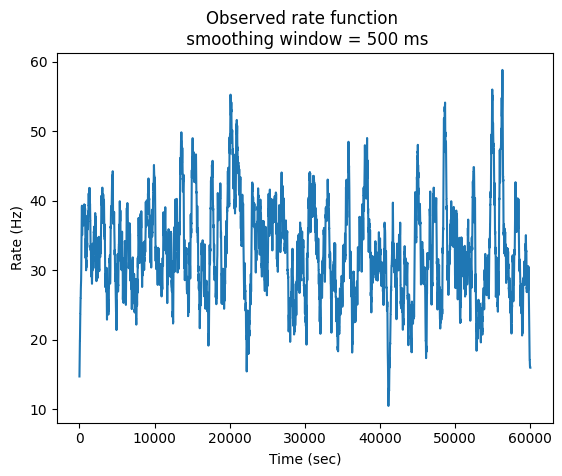

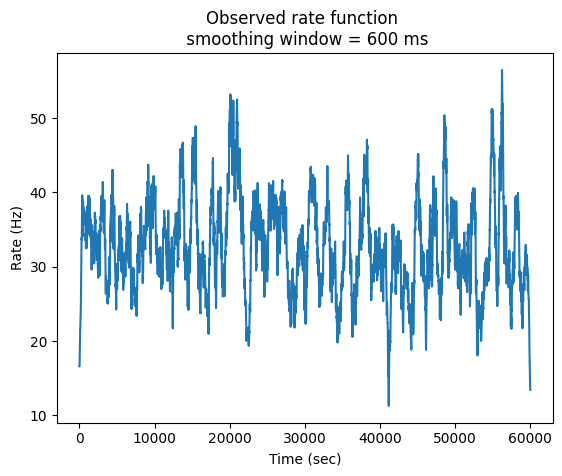

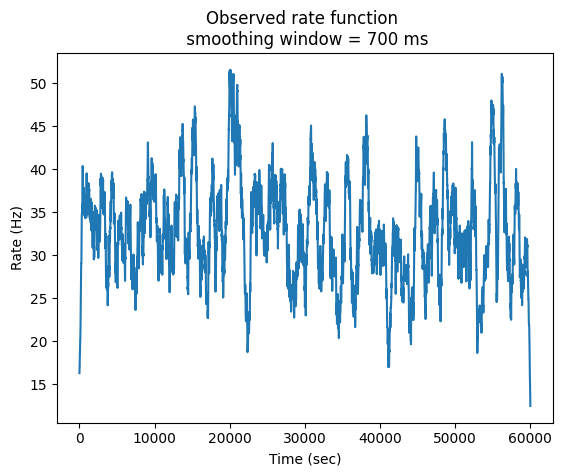

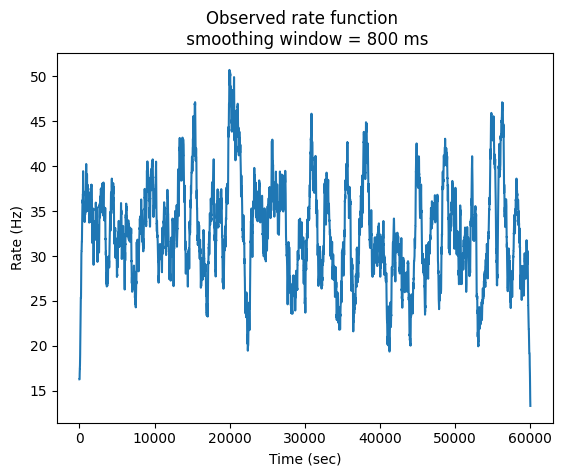

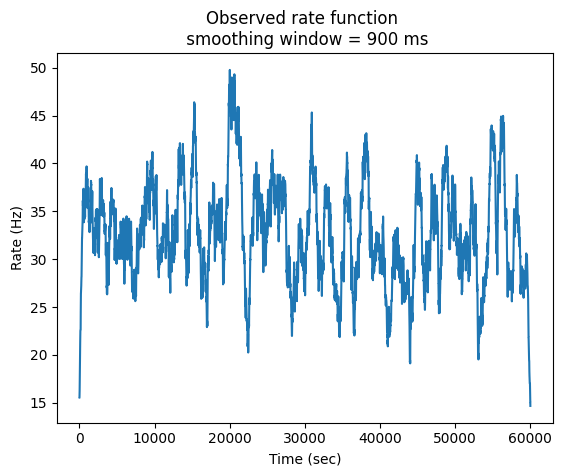

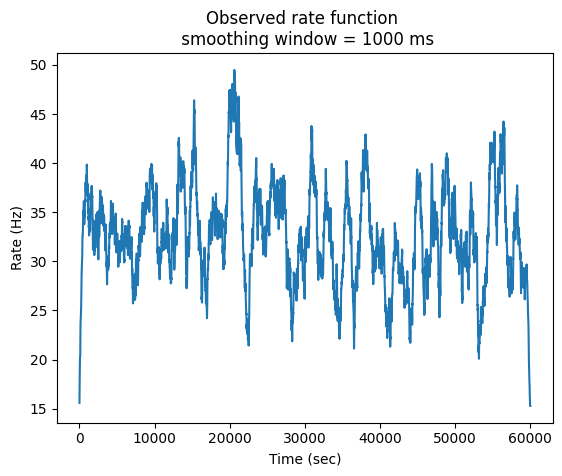

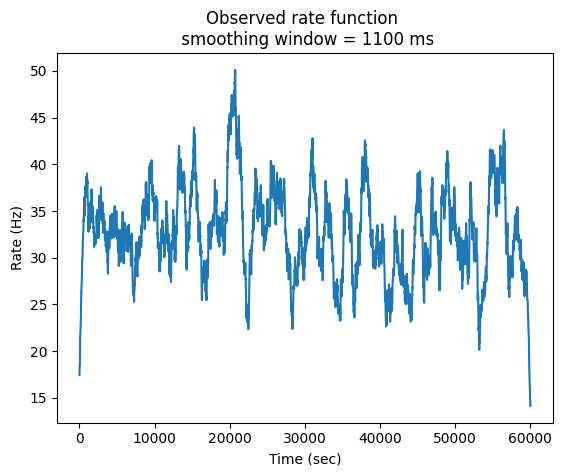

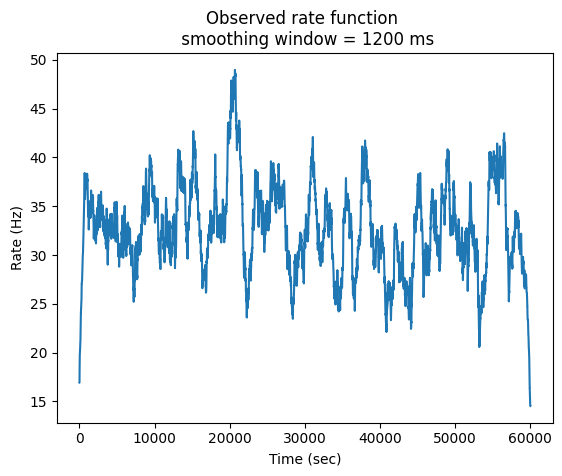

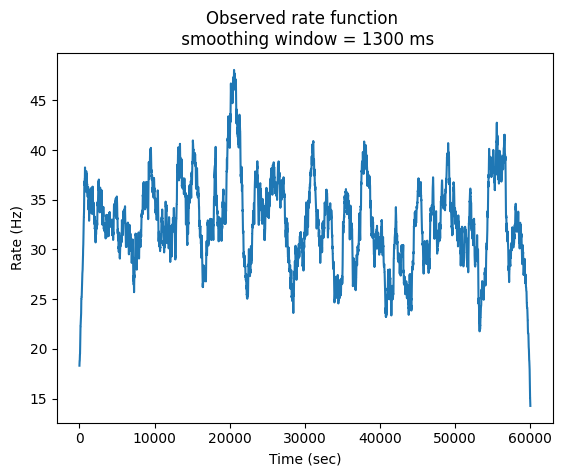

In [8]:
windows = np.arange(100, 1400, 100) #varying window lengths
rate_observed = dict()
for window in windows:
    unity = np.ones(window,)/window
    # Smoothing the average response (averaged over 100 trials in 1ms resolution), smoothed with a uniform distribution,
    # multiplied by a 1000 to move from spike/ms to spike/second resolution.
    rate_observed[window] = np.convolve(unity, np.mean(resp_white, axis=0), mode='same')*1000
    plt.figure()
    plt.plot(rate_observed[window])
    plt.title(f'Observed rate function \n smoothing window = {window} ms')
    plt.xlabel('Time (sec)')
    plt.ylabel('Rate (Hz)')


I choose a window of 800ms because it smooths out the spiking to get the firing rate and still it has enough resolution in time. 

In [20]:
# finding the optimal kernel using a reverse correlation (aka convolution) of the spike train and the stimulus (STA).
r_average = np.mean(resp_white)*1000 
var_stimulus = np.var(white_stim)
STA_dict = dict()
kernel = dict()
window = 800
half_window = int(window/2)
sta = np.zeros((window,)) # initialize the sta vector
for i, trial in enumerate(resp_white):
    # calculate the sta for each trial by convolution, average by the amount of trials and the number
    sta+=np.correlate(np.flip(trial), np.flip(white_stim))[int(len(sta)/2-half_window):int(len(sta)/2+half_window)] 
STA_dict[window]=sta/(10000*800)
kernel[window] = r_average*STA_dict[window]/var_stimulus

Text(0, 0.5, 'au')

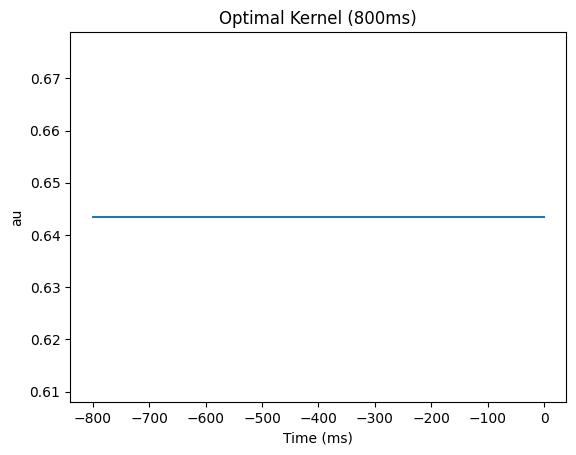

In [21]:
x = np.arange(-800, 0)
plt.plot(x, kernel[800])
plt.title('Optimal Kernel (800ms)')
plt.xlabel('Time (ms)')
plt.ylabel('au')

In [24]:
r_estimated = dict()
r_estimated[800] = r_average + np.convolve(white_stim, kernel[800], mode='same') # get the estimated rate by convolution of the kernel and the stimulation

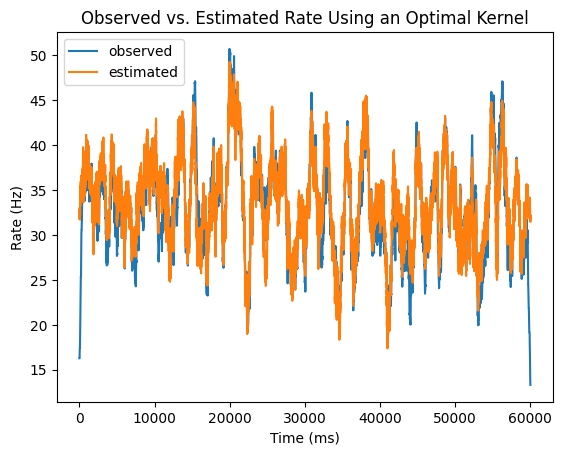

In [25]:
# plot the estimated and the observed rate:
plt.plot(rate_observed[800], label='observed') 
plt.plot((r_estimated[800]), label='estimated')
plt.title('Observed vs. Estimated Rate Using an Optimal Kernel')
plt.xlabel('Time (ms)')
plt.ylabel('Rate (Hz)')
plt.legend()

In [39]:
# finding the optimal kernel using the function calculate_STA from question 2.
r_average = np.mean(resp_white)*1000 # mean rate in Hz
var_stimulus = np.var(white_stim)
STA_dict = dict()
kernel = dict()
for window in windows:
    sta = np.zeros((2*window,))
    for i, trial in enumerate(resp_white):
        sta+=calculate_STA(trial, white_stim, window) # STA +- window
    STA_dict[window]=sta/(1000) # averaged by the number of trials
    kernel[window] = (r_average*STA_dict[window]/var_stimulus) # optimal kernelby equation 

Text(0, 0.5, 'au')

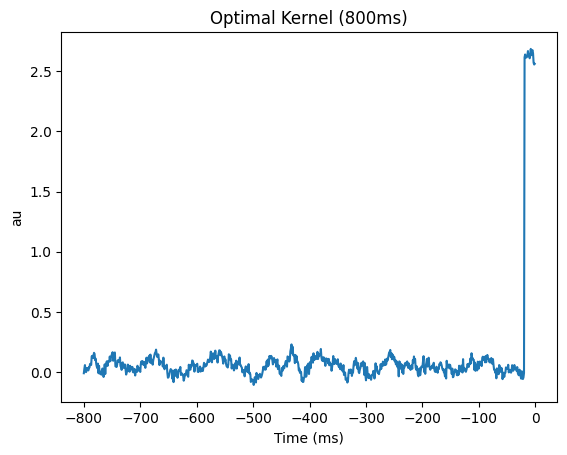

In [40]:
x = np.arange(-800, 0)
plt.plot(x, kernel[800][0:800]) # get only the first have of the STA which is in the length of our window, and looks only on prior stimuli
plt.title('Optimal Kernel (800ms)')
plt.xlabel('Time (ms)')
plt.ylabel('au')

In [43]:
r_estimated = dict()
r_estimated[800] = r_average + np.correlate(white_stim, kernel[800][0:800], mode='same') # get the estimated rate by convolution of the kernel and the stimulation

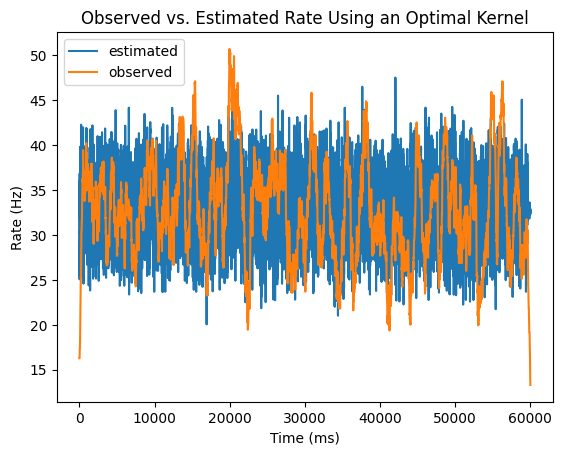

In [44]:
# plot the estimated and the observed rate:
plt.plot(r_estimated[800], label='estimated')
plt.plot(rate_observed[800], label='observed')
plt.title('Observed vs. Estimated Rate Using an Optimal Kernel')
plt.xlabel('Time (ms)')
plt.ylabel('Rate (Hz)')
plt.legend()